In [1]:
from brainlit.utils import session
from brainlit.feature_extraction import *
import napari

In [2]:
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
sess = session.NeuroglancerSession(url=url, url_segments=url+"_segments", mip=0)

In [3]:
nbr = NeighborhoodFeatures(url="file://../../../data/upload", size=1, offset=[15,15,15], segment_url="file://../../../data/upload_segments")
nbr.fit(seg_ids=[2], num_verts=10, file_path='demo', batch_size=10)

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]


In [3]:
import glob, feather
feathers = glob.glob('*.feather')


for count, feather_file in enumerate(feathers):
    if count == 0:
        data = feather.read_dataframe(feather_file)
    else:
        df = feather.read_dataframe(feather_file)
        data = pd.concat([data, df])
data.head()

,Segment,Vertex,Label,0,1,2,3,4,5,6,...,17,18,19,20,21,22,23,24,25,26
0,2,0,1,36479,64965,12557,22118,36183,12687,25162,...,13560,29534,37050,12628,23703,16093,12727,21276,20142,13125
1,2,0,0,12362,12375,12413,12291,12371,12430,12255,...,12340,12419,12400,12399,12356,12451,12351,12276,12385,12358
2,2,1,1,21814,36775,13604,64328,65520,13591,65388,...,12727,26907,20743,12495,35453,22926,12571,12682,13579,12534
3,2,1,0,12355,12393,12420,12452,12384,12403,12289,...,12351,12336,12403,12386,12342,12371,12381,12323,12392,12425
4,2,2,1,23765,12774,12582,15534,13590,12459,21999,...,12484,12677,13744,12489,14686,13540,12480,17840,13513,12469


In [18]:
X = data.iloc[:, 3:]
y = data["Label"]

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_score = clf.predict(X_test)

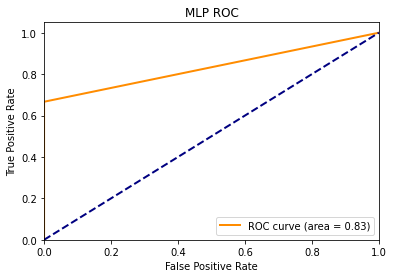

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC')
plt.legend(loc="lower right")
plt.show()

In [11]:
X.iloc[:, 14]

0    13823
1    12363
2    12628
3    12399
4    12537
5    12336
6    12485
7    12241
8    12774
9    12279
0    12893
1    12316
2    17840
3    12328
4    13947
5    12335
6    13570
7    12210
8    12388
9    12195
Name: 14, dtype: int64

In [22]:
from sklearn.linear_model import LogisticRegression
X_center = X.iloc[:, 14].values.reshape(-1,1)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_center, y, stratify=y, random_state=1)
clf = LogisticRegression(random_state=0).fit(Xc_train, yc_train)
yc_score = clf.predict(Xc_test)

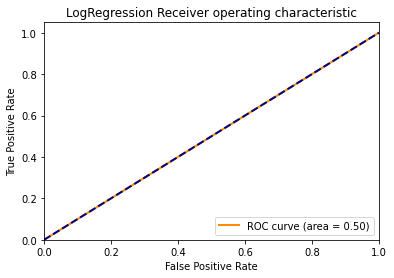

In [23]:
fpr_c, tpr_c, _ = roc_curve(yc_test, yc_score)
roc_auc_c = auc(fpr_c, tpr_c)

plt.figure()
lw = 2
plt.plot(fpr_c, tpr_c, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_c)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogRegression Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()